In [1]:
from scipy.io.wavfile import read, write
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import pandas as pd

In [45]:
rate, data = read("data/data.wav")
data = data.astype(np.int16)

print(f"Częstotliwosc próbkowania: {rate} Hz")
print(f"Liczba próbek sygnału: {len(data)}")

Częstotliwosc próbkowania: 11025 Hz
Liczba próbek sygnału: 270113


In [46]:
def get_autocorr_coeff(data: np.ndarray, max_lag: int = 10) -> List:
    data_pd = pd.Series(data)
    autocorr_coeffs = []
    
    for i in range(max_lag+1):
        autocorr_coeffs.append(data_pd.autocorr(i).item())

    return autocorr_coeffs

# def get_autocorr_coeff(data: np.ndarray, max_lag: int = 10) -> List:
#     p_list = []
#     p_list.append(np.mean(data*data))   # Add p_0

#     for i in range(1, max_lag+1):
#         p_list.append(np.mean(data[i:]*data[:-i]))

#     return p_list

In [47]:
# Removes empty coefficients added in calculate_levinson_durbin to keep indexing from 1
def clean_coeff_list(coeff_list: List) -> List:
    del coeff_list[0]
    return [coeffs[1:] for coeffs in coeff_list]

# Given reflection coefficients returns True if AR model is stable
def check_stability(refl_coeffs: List) -> bool:
    for refl_coeff in refl_coeffs:
        if np.abs(refl_coeff) >= 1:
            return False
    return True

def calculate_levinson_durbin(data: np.ndarray, r_max: int = 10) -> Tuple:
    p_list = get_autocorr_coeff(data, r_max)

    sigmas = []
    sigmas.append(p_list[0])    # Add sigma_0

    a_list = [[0] for _ in range(0, r_max+1)]   # Adding 0 to every list to start indexing from 1 possible later
    k_list = []     # Reflection coefficients
    for i in range(1, r_max+1):
        p_i = p_list[i]

        z = 0   # Sum from j=1 to i-1 a_j,i-1(N)*p(i-j)(N)

        for j in range(1, i):
            z += a_list[i-1][j]*p_list[i-j]
        ki = (p_i - z) / sigmas[i-1]
        k_list.append(ki)

        for j in range(1, i+1):
            if j == i:
                a_list[i].append(ki)
            else:
                a_list[i].append(a_list[i-1][j]-ki*a_list[i-1][i-j])

        sigma = (1-ki**2)*sigmas[i-1]
        sigmas.append(sigma)

    a_list = clean_coeff_list(a_list)
    return a_list, k_list


import numpy as np

def quantize_n_bit(arr, n, max_val):
    # Step 1: Normalize input array to [-1, 1]
    arr_norm = arr / max_val
    
    # Step 2: Define int quantization range
    qmin = -2**(n-1)
    qmax = 2**(n-1) - 1
    
    # Step 3: Scale to quantization range and round
    arr_scaled = arr_norm * qmax
    arr_quant = np.round(arr_scaled)
    
    # Optional step 4: De-quantize back to original float range
    arr_dequant = arr_quant / qmax * max_val
    
    return arr_quant, arr_dequant

In [48]:
class ARModel:
    def __init__(self, order: int = 4) -> None:
        self.order = order
        self.theta = np.zeros((order,1), dtype=np.float64)

    def set_coeffs(self, coeffs: np.ndarray) -> None:
        self.theta = coeffs

    def _predict(self, x: np.ndarray) -> float:
        return float(self.theta.T @ x)

# Nadajnik

In [49]:
class Transmitter:
    def __init__(self, ar_order: int = 10, segment_width: int = 256, overlap: int = 10) -> None:
        self.segment_width = segment_width
        self.overlap = overlap
        self.ar_model = ARModel(order=ar_order)

    def forward(self, data: np.ndarray) -> Tuple:
        segmented_data = self._prepare_data(data)

        errors_list = []
        coeffs_list = []
        targets_list = []
        predictions_list = []
        for segment in segmented_data:
            ar_model_coeffs, refl_coeffs = calculate_levinson_durbin(segment)
            ar_model_coeffs = ar_model_coeffs[-1]
            self.ar_model.set_coeffs(np.flip(np.array(ar_model_coeffs, dtype=np.float32)))
            
            targets = []
            predictions = []
            segment_errors = []
            for i in range(self.ar_model.order, len(segment)):
                curr_data = segment[i-self.ar_model.order:i]
                prediction = self.ar_model._predict(curr_data)
                target = segment[i]
                error = target - prediction
                segment_errors.append(error)
                predictions.append(prediction)
                targets.append(target)
            
            errors_list.append(segment_errors)
            coeffs_list.append(ar_model_coeffs)
            predictions_list.append(predictions)
            targets_list.append(targets)

        errors_list = np.array(errors_list)
        coeffs_list = np.array(coeffs_list)
        predictions_list = np.array(predictions_list)
        targets_list = np.array(targets_list)

        return coeffs_list, errors_list, predictions_list, targets_list, refl_coeffs, segmented_data

    # Given data cuts it into segments with specified overlap
    def _prepare_data(self, data: np.ndarray) -> np.ndarray:
        n_segments = len(data) // (self.segment_width - self.overlap)

        segments = []
        for i in range(n_segments):
            start_index = i*self.segment_width-i*self.overlap
            end_index = start_index+self.segment_width
            segment = data[start_index:end_index]

            # Drop last segment if it's length is not equal to segment width
            if i == n_segments-1 and len(segment) != self.segment_width:
                break

            # segment = self._flatten_segment_ends(segment)
            segments.append(segment)

        return np.array(segments)
    
    def _flatten_segment_ends(self, segment: np.ndarray) -> np.ndarray:
        cos_arg = (2*np.pi / (len(segment)+1))*np.arange(1, len(segment)+1)
        return 0.5*(1 - np.cos(cos_arg))*segment

In [50]:
transmitter = Transmitter()

In [51]:
coeffs, errors, predictions_list, targets_list, refl_coeffs, segmented_data = transmitter.forward(data)

### Sprawdzenie stabilności

In [52]:
check_stability(refl_coeffs)

True

In [56]:
np.mean(np.abs(errors))

np.float64(132.86715643770233)

# Odbiornik

In [57]:
class Receiver:
    def __init__(self, ar_order: int = 10, segment_width: int = 256, overlap: int = 10):
        self.segment_width = segment_width
        self.overlap = overlap
        self.ar_model = ARModel(order=ar_order)

    def forward(self, errors: np.ndarray, coeffs: np.ndarray, init_data: np.ndarray):
        reconstructed_data = []
        reconstructed_data.extend(init_data.tolist())    # Add initial data to the beginning

        for i, (segment_errors, ar_model_coeffs) in enumerate(zip(errors, coeffs)):            

            # Set AR model coefficients for current segment
            self.ar_model.set_coeffs(np.flip(np.array(ar_model_coeffs, dtype=np.float32)))

            for j in range(len(segment_errors)):
                curr_data = np.array(reconstructed_data[-self.ar_model.order:], dtype=np.float32)
                prediction = self.ar_model._predict(curr_data)
                reconstructed_value = prediction + segment_errors[j]
                reconstructed_data.append(reconstructed_value)

        return np.array(reconstructed_data)

In [58]:
receiver = Receiver()

In [70]:
n = 16
max_val = errors.max()
q, quantized_errors = quantize_n_bit(errors, n, max_val)
print("Quantized:", q)
print("Dequantized:", errors)

Quantized: [[-0.  0. -0. ... -0.  0. -0.]
 [-0.  0.  0. ... -0.  0. -0.]
 [-0.  0. -0. ...  1. -0.  0.]
 ...
 [ 2. -4. -1. ... -1.  0.  2.]
 [-1.  1. -0. ...  0. -0.  1.]
 [-0. -0. -0. ...  0. -0.  0.]]
Dequantized: [[-1.50835514e-01  1.13378167e-01 -6.90872669e-01 ... -7.65343428e-01
   8.60742331e-02 -4.98941064e-01]
 [-1.08115590e+00  3.98359835e-01  1.53903884e+00 ... -1.63879383e+00
   1.18456483e-02 -1.06454611e-01]
 [-7.56225765e-01  4.83069062e-01 -5.40327549e-01 ...  1.96125412e+00
  -1.60206079e+00  4.37200069e-03]
 ...
 [ 5.19828796e+00 -1.45434418e+01 -3.04887390e+00 ... -2.27391505e+00
   1.23086309e+00  5.65110481e+00]
 [-2.06841576e+00  3.04565334e+00 -1.15676570e+00 ...  8.44123125e-01
  -1.05934668e+00  1.70578814e+00]
 [-6.98694468e-01 -8.32280159e-01 -4.70404863e-01 ...  2.97431946e-02
  -1.22431278e-01  1.36457115e+00]]


In [73]:
reconstructed_data = receiver.forward(errors, coeffs, init_data=data[:10])

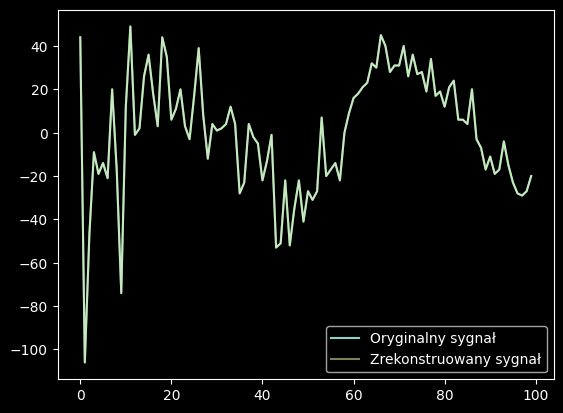

In [78]:
start_index = 1000
end_index = 1100

plt.plot(data[start_index:end_index], label="Oryginalny sygnał")
plt.plot(reconstructed_data[start_index:end_index], label="Zrekonstruowany sygnał", alpha=0.5)
plt.legend()
plt.show()